## VCB

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Nadam

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# Load data
data = pd.read_csv('../../Dataset/VCB.csv')
df = data[['Date','Close']]
df.rename(columns={'Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df.set_index('Date',inplace=True)
y = df['Price'].values.reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)

# Split data into train and test (90/10)
train_size = int(len(y_norm) * 0.9)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]

# Create input and output sequences
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1  # Predict time step
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Build and train the model
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(n_lookback,))) 
model.add(Dense(50, activation='relu'))                           
model.add(Dense(n_forecast))                                       

optimizer = Nadam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.fit(X_train.reshape(X_train.shape[0], -1), Y_train, epochs=200, validation_data=(X_test, Y_test), batch_size=32, verbose=1)

# Evaluate on the test set
Y_pred_test = model.predict(X_test.reshape(X_test.shape[0], -1))
Y_pred_test = scaler.inverse_transform(Y_pred_test)

# Reshape Y_test before inverse transforming
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))  # Reshape to 2D

# Predict future 30, 60, 90 days
last_sequence = y_norm[-n_lookback:].reshape(1, -1)
future_predictions = []
for i in range(90):
    next_pred = model.predict(last_sequence)
    future_predictions.append(next_pred)
    last_sequence = np.concatenate([last_sequence[:, 1:], next_pred], axis=1)  
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

Epoch 1/200


c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0367 - val_loss: 0.0034
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.7669e-04 - val_loss: 0.0035
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.6128e-04 - val_loss: 0.0038
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1463e-04 - val_loss: 0.0042
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8706e-04 - val_loss: 0.0046
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7070e-04 - val_loss: 0.0047
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.5007e-04 - val_loss: 0.0048
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3813e-04 - val_loss: 0.0046
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2782e-04 - val_loss: 0.0043
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0946e-04 - val_loss: 0.0042
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9511e-04 - val_loss: 0.0044
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━

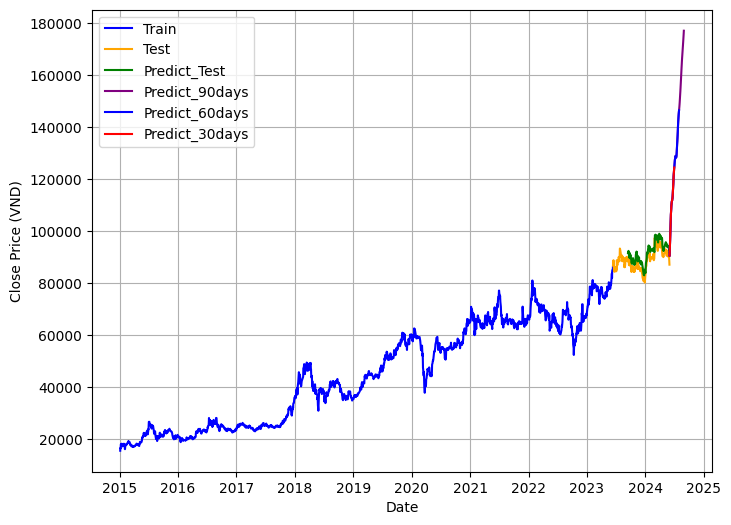

In [2]:
# Visualization
plt.figure(figsize=(8, 6))

# Plot actual prices (All data)
plt.plot(df.index[:train_size], df['Price'][:train_size], label='Train', color='blue')

plt.plot(df.index[train_size:], df['Price'][train_size:], label='Test', color='orange')

# Plot predicted prices on the test set
test_data_start = df.index[train_size + n_lookback]  
test_data_end = df.index[-1]
plt.plot(df.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback], Y_pred_test, label='Predict_Test', color='green')


# Plot predicted prices in the future
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:]  # Ngày bắt đầu sau ngày cuối cùng của dữ liệu
plt.plot(future_dates, future_predictions, label='Predict_90days', color='purple')
plt.plot(future_dates[:60], future_predictions[:60], label='Predict_60days', color='blue')
plt.plot(future_dates[:30], future_predictions[:30], label='Predict_30days', color='red')

# plt.title('VCB Stock Price Forecast using LSTM 9:1')
plt.xlabel('Date')
plt.ylabel('Close Price (VND)')
plt.legend()
plt.grid(True)  
plt.show()

In [3]:
# Create a new dataframe containing dates and future predicted values
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:] 
future_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_predictions.flatten()}) 
future_df.set_index('Date', inplace=True)

# Print the forecast results for the next 90 days
print("Forecast VCB stock prices for the next 90 days:")
print(future_df)


Forecast VCB stock prices for the next 90 days:
                 Forecast
Date                     
2024-06-01   90722.476562
2024-06-02   92454.351562
2024-06-03   94462.718750
2024-06-04   96367.210938
2024-06-05   98485.328125
...                   ...
2024-08-25  172994.859375
2024-08-26  173946.984375
2024-08-27  174945.843750
2024-08-28  176000.703125
2024-08-29  177127.281250

[90 rows x 1 columns]


In [4]:
# Calculate RMSE, MAPE, and MAE on the test set
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mae

rmse, mape, mae = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MAE:', mae)

RMSE: 3001.917900903312
MAPE: 3.1602975132478552 %
MAE: 2809.841370330462


## CTG

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# Load data
data = pd.read_csv('../../Dataset/CTG.csv')
df = data[['Date','Close']]
df.rename(columns={'Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df.set_index('Date',inplace=True)
y = df['Price'].values.reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)

# Split data into train and test (90/10)
train_size = int(len(y_norm) * 0.9)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]

# Create input and output sequences
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1  # Predict time step
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Build and train the model
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(n_lookback,))) 
model.add(Dense(50, activation='relu'))                          
model.add(Dense(n_forecast))                                      

optimizer = Nadam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.fit(X_train.reshape(X_train.shape[0], -1), Y_train, epochs=200, validation_data=(X_test, Y_test), batch_size=32, verbose=1)

# Evaluate on the test set
Y_pred_test = model.predict(X_test.reshape(X_test.shape[0], -1))
Y_pred_test = scaler.inverse_transform(Y_pred_test)

# Reshape Y_test before inverse transforming
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))  # Reshape to 2D

# Predict future 30, 60, 90 days
last_sequence = y_norm[-n_lookback:].reshape(1, -1)
future_predictions = []
for i in range(90):
    next_pred = model.predict(last_sequence)
    future_predictions.append(next_pred)
    last_sequence = np.concatenate([last_sequence[:, 1:], next_pred], axis=1)  
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

Epoch 1/200


c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0233 - val_loss: 0.0028
Epoch 2/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 3/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.3443e-04 - val_loss: 0.0032
Epoch 4/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.5832e-04 - val_loss: 0.0017
Epoch 5/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.7242e-04 - val_loss: 0.0017
Epoch 6/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.4717e-04 - val_loss: 9.7468e-04
Epoch 7/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.1264e-04 - val_loss: 8.4098e-04
Epoch 8/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.8772e-04 - val_loss: 8.0898e-04
Epoch 9/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.4541e-04 - val_loss: 0.0011
Epoch 10/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.5871e-04 - val_loss: 8.6118e-04
Epoch 11/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.2314e-04 - val_loss: 9.0840e-04
Epoch 12/200
65/65 

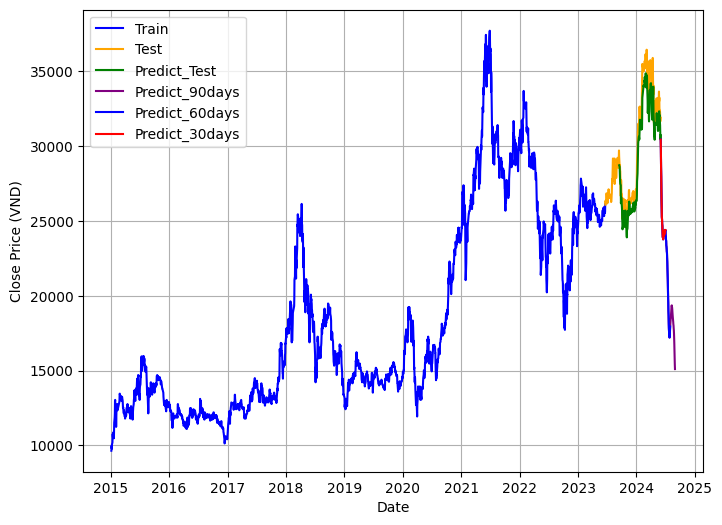

In [6]:
# Visualization
plt.figure(figsize=(8, 6))

# Plot actual prices (All data)
plt.plot(df.index[:train_size], df['Price'][:train_size], label='Train', color='blue')

plt.plot(df.index[train_size:], df['Price'][train_size:], label='Test', color='orange')

# Plot predicted prices on the test set
test_data_start = df.index[train_size + n_lookback]  
test_data_end = df.index[-1]
plt.plot(df.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback], Y_pred_test, label='Predict_Test', color='green')


# Plot predicted prices in the future
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:]  # Ngày bắt đầu sau ngày cuối cùng của dữ liệu
plt.plot(future_dates, future_predictions, label='Predict_90days', color='purple')
plt.plot(future_dates[:60], future_predictions[:60], label='Predict_60days', color='blue')
plt.plot(future_dates[:30], future_predictions[:30], label='Predict_30days', color='red')

# plt.title('CTG Stock Price Forecast using MLP 9:1')
plt.xlabel('Date')
plt.ylabel('Close Price (VND)')
plt.legend()
plt.grid(True)  
plt.show()

In [7]:
# Create a new dataframe containing dates and future predicted values
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:] 
future_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_predictions.flatten()}) 
future_df.set_index('Date', inplace=True)

# Print the forecast results for the next 90 days
print("Forecast VCB stock prices for the next 90 days:")
print(future_df)


Forecast VCB stock prices for the next 90 days:
                Forecast
Date                    
2024-06-01  30432.623047
2024-06-02  29809.634766
2024-06-03  28612.056641
2024-06-04  27953.843750
2024-06-05  27056.630859
...                  ...
2024-08-25  16755.232422
2024-08-26  16290.773438
2024-08-27  15831.541016
2024-08-28  15392.910156
2024-08-29  15096.676758

[90 rows x 1 columns]


In [8]:
# Calculate RMSE, MAPE, and MAE on the test set
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mae

rmse, mape, mae = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MAE:', mae)

RMSE: 1225.713555023307
MAPE: 3.434992875379113 %
MAE: 1064.4898549107143


## BID

In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# Load data
data = pd.read_csv('../../Dataset/BID.csv')
df = data[['Date','Close']]
df.rename(columns={'Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df.set_index('Date',inplace=True)
y = df['Price'].values.reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)

# Split data into train and test (90/10)
train_size = int(len(y_norm) * 0.9)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]

# Create input and output sequences
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1  # Predict time step
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Build and train the model
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(n_lookback,))) 
model.add(Dense(50, activation='relu'))                            
model.add(Dense(n_forecast))        
                               
optimizer = Nadam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.fit(X_train.reshape(X_train.shape[0], -1), Y_train, epochs=200, validation_data=(X_test, Y_test), batch_size=32, verbose=1)

# Evaluate on the test set
Y_pred_test = model.predict(X_test.reshape(X_test.shape[0], -1))
Y_pred_test = scaler.inverse_transform(Y_pred_test)

# Reshape Y_test before inverse transforming
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))  # Reshape to 2D

# Predict future 30, 60, 90 days
last_sequence = y_norm[-n_lookback:].reshape(1, -1)
future_predictions = []
for i in range(90):
    next_pred = model.predict(last_sequence)
    future_predictions.append(next_pred)
    last_sequence = np.concatenate([last_sequence[:, 1:], next_pred], axis=1)  
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

Epoch 1/200


c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0125 - val_loss: 0.0057
Epoch 2/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 3/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.2626e-04 - val_loss: 0.0018
Epoch 4/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0910e-04 - val_loss: 0.0011
Epoch 5/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5972e-04 - val_loss: 7.7596e-04
Epoch 6/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3572e-04 - val_loss: 6.8464e-04
Epoch 7/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1957e-04 - val_loss: 7.0686e-04
Epoch 8/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.0551e-04 - val_loss: 7.4952e-04
Epoch 9/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.9585e-04 - val_loss: 7.9834e-04
Epoch 10/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8470e-04 - val_loss: 8.8120e-04
Epoch 11/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7580e-04 - val_loss: 9.5680e-04
Epoch 12/20

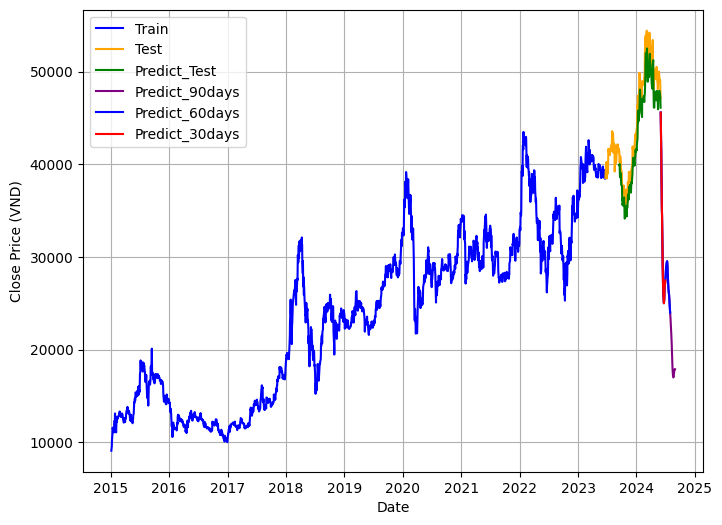

In [10]:
# Visualization
plt.figure(figsize=(8, 6))

# Plot actual prices (All data)
plt.plot(df.index[:train_size], df['Price'][:train_size], label='Train', color='blue')

plt.plot(df.index[train_size:], df['Price'][train_size:], label='Test', color='orange')

# Plot predicted prices on the test set
test_data_start = df.index[train_size + n_lookback]  
test_data_end = df.index[-1]
plt.plot(df.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback], Y_pred_test, label='Predict_Test', color='green')


# Plot predicted prices in the future
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:]  # Ngày bắt đầu sau ngày cuối cùng của dữ liệu
plt.plot(future_dates, future_predictions, label='Predict_90days', color='purple')
plt.plot(future_dates[:60], future_predictions[:60], label='Predict_60days', color='blue')
plt.plot(future_dates[:30], future_predictions[:30], label='Predict_30days', color='red')

# plt.title('VCB Stock Price Forecast using LSTM 7:3')
plt.xlabel('Date')
plt.ylabel('Close Price (VND)')
plt.legend()
plt.grid(True)  
plt.show()

In [11]:
# Create a new dataframe containing dates and future predicted values
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:] 
future_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_predictions.flatten()}) 
future_df.set_index('Date', inplace=True)

# Print the forecast results for the next 90 days
print("Forecast VCB stock prices for the next 90 days:")
print(future_df)


Forecast VCB stock prices for the next 90 days:
                Forecast
Date                    
2024-06-01  45569.203125
2024-06-02  44234.917969
2024-06-03  42671.953125
2024-06-04  41420.628906
2024-06-05  39671.718750
...                  ...
2024-08-25  17728.990234
2024-08-26  17811.179688
2024-08-27  17885.664062
2024-08-28  17915.220703
2024-08-29  17902.724609

[90 rows x 1 columns]


In [12]:
# Calculate RMSE, MAPE, and MAE on the test set
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mae

rmse, mape, mae = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MAE:', mae)

RMSE: 1925.2545694787373
MAPE: 3.8260167175909277 %
MAE: 1747.5299553571429
